# Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## Methods to calculate the size of images before and after compression
The function array_size_mb calculates the size of a numpy array in megabytes. It converts the size from bytes to kilobytes, and then to megabytes.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

def array_size_mb(arr):
    # Number of bytes
    total_bytes = arr.nbytes
    # Size in kilobytes (KB)
    size_in_kb = total_bytes / 1024
    # Size in megabytes (MB)
    size_in_mb = size_in_kb / 1024
    return size_in_mb


## Prepare the CIFAR10 dataset

This section sets up the CIFAR-10 dataset for training and testing. The transform variable normalizes the images and converts them to PyTorch tensors. The train_dataset and test_dataset variables download the CIFAR-10 dataset, applying the transformations. The train_loader and test_loader variables create data loaders for iterating over the training and test datasets.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


## Define the AutoEncoder model
This section defines the Autoencoder model using PyTorch. The model consists of an encoder, fully connected layers (bottleneck), and a decoder. The encoder compresses the input image into a latent representation, while the decoder reconstructs the image from this representation.

![Example Image](img/auto-encoder.png)


In [4]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        
        # Fully connected layers to create the bottleneck
        self.fc1 = nn.Linear(16 * 8 * 8, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 16 * 8 * 8)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.size(0), 16, 8, 8)  # Reshape
        x = self.decoder(x)
        return x

## Train the model

In [5]:
# Initialize the model, loss function, and optimizer
model = Autoencoder(latent_dim=1024).to(device) 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Compile and Train the Model
num_epochs = 5

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.1821
Epoch [2/5], Loss: 0.1384
Epoch [3/5], Loss: 0.1237
Epoch [4/5], Loss: 0.1810
Epoch [5/5], Loss: 0.1862


## Evaluate the model on a single batch and display the results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input d

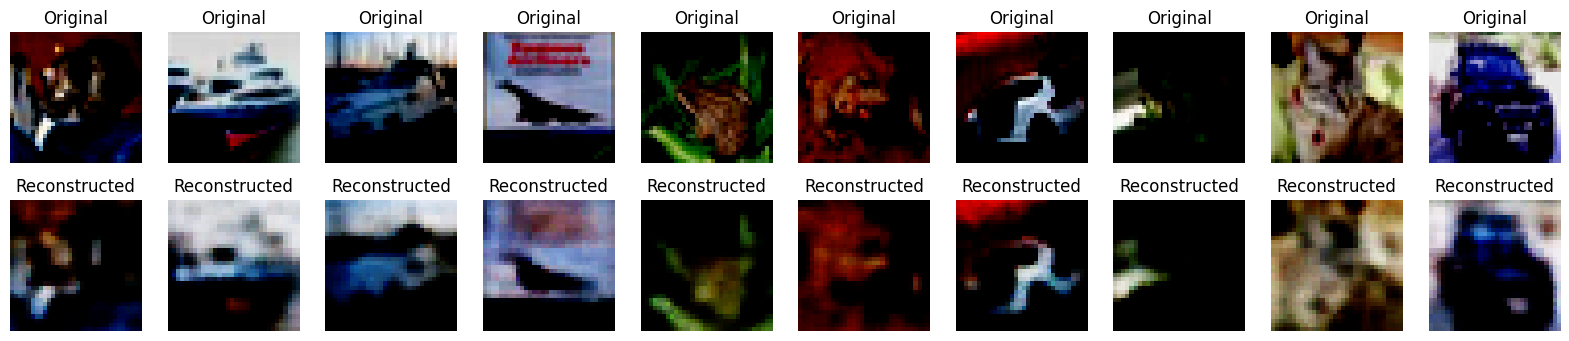

In [6]:
model.eval()

# Get some test images and their reconstructions
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)
output = model(images)

# Move the images back to CPU for visualization
images = images.cpu().detach().numpy()
output = output.cpu().detach().numpy()

# Visualize the results
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].transpose((1, 2, 0)))
    plt.title("Original")
    plt.axis('off')

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output[i].transpose((1, 2, 0)))
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

## Compress the images using the encoder and compare the sizes

In [7]:
model.eval()
model.to(device)
compressed_images, original_images = [], []
for images, labels in test_loader:
    images = images.to(device)
    output = model.encoder(images)
    original_images.append(images.cpu().detach().numpy())
    compressed_images.append(output.cpu().detach().numpy())

compressed_images = np.array(compressed_images)
original_images = np.array(original_images)


In [8]:
images.shape, output.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 16, 8, 8]))

## The compression reduced the size by 67%!

In [9]:
compressed_size = array_size_mb(compressed_images)
original_size = array_size_mb(original_images)

reduction = original_size - compressed_size
percentage = (reduction / original_size) * 100

percentage

66.66666666666666

## Plot the construction error as a function of compression percentage

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10/10 [00:59<00:00,  5.98s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


Latent Dim: 2048, Compression: 33.33%, Reconstruction Error: 0.1465


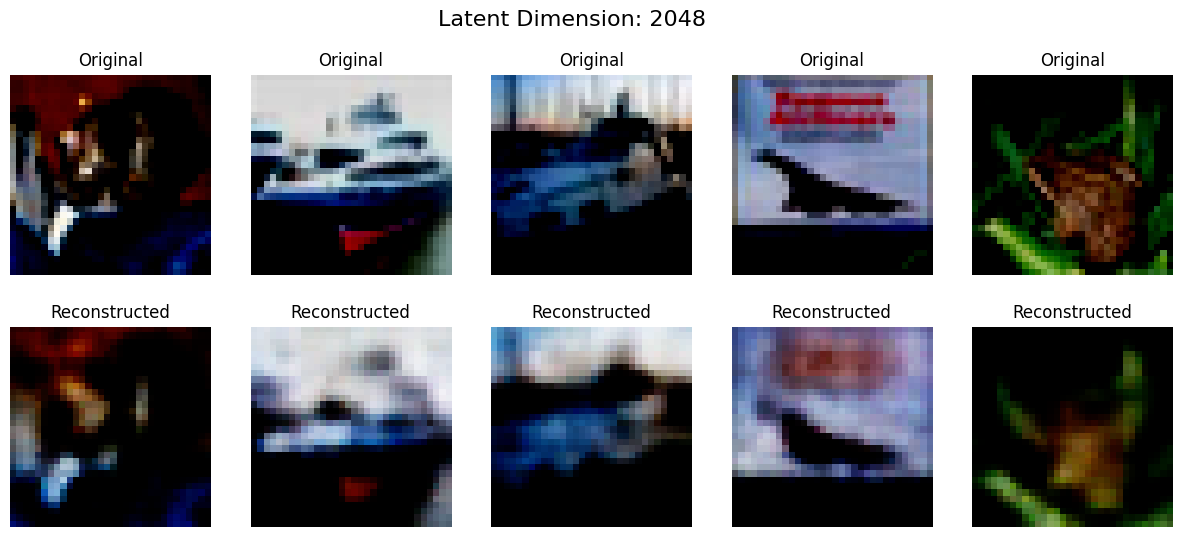

100%|██████████| 10/10 [00:56<00:00,  5.65s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


Latent Dim: 1024, Compression: 66.67%, Reconstruction Error: 0.1466


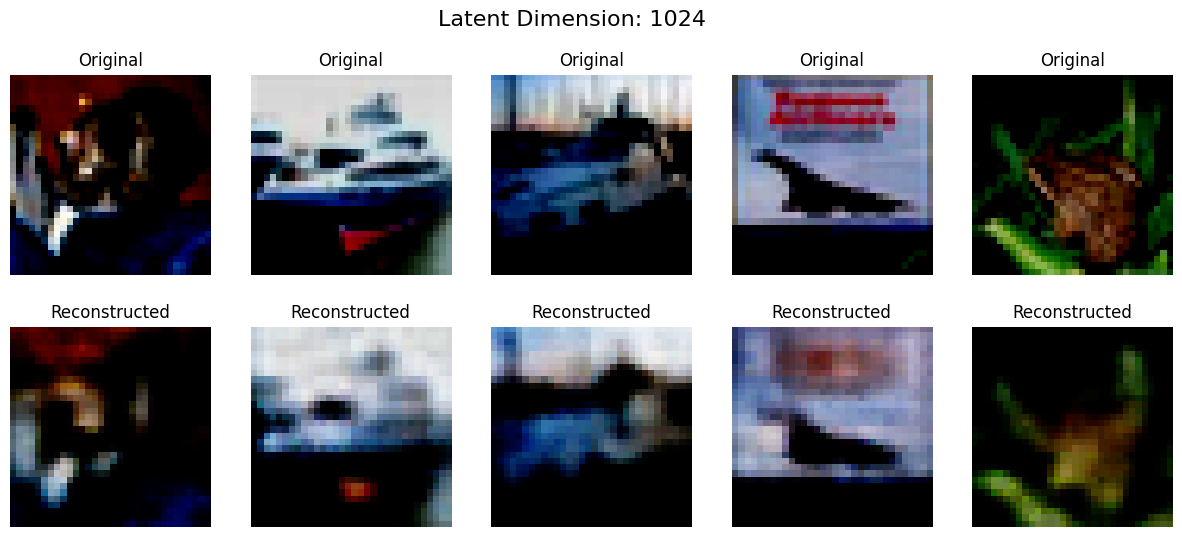

100%|██████████| 10/10 [00:55<00:00,  5.58s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


Latent Dim: 512, Compression: 83.33%, Reconstruction Error: 0.1470


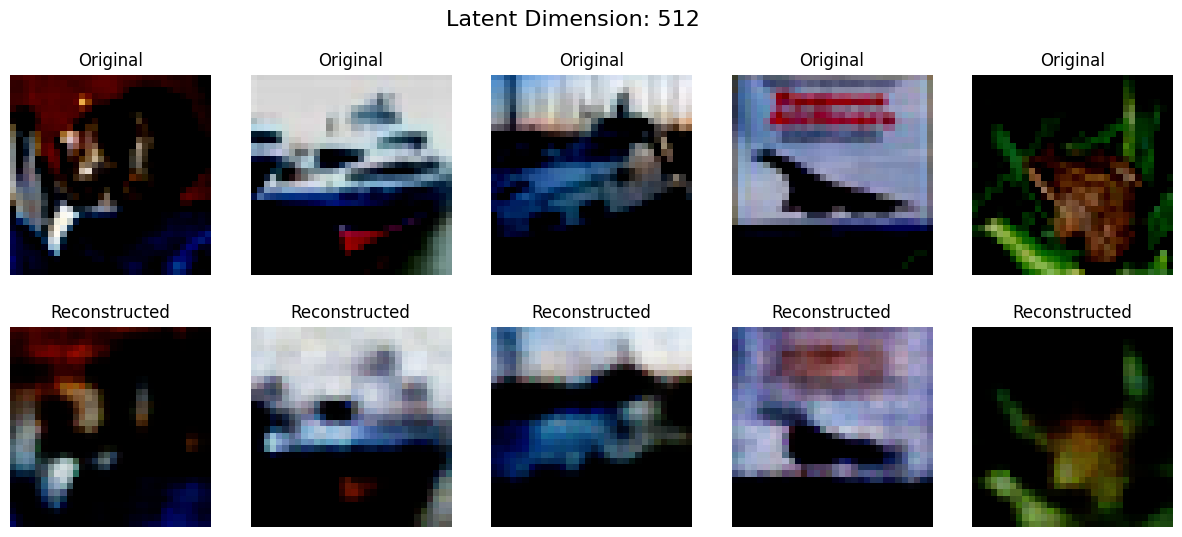

100%|██████████| 10/10 [00:54<00:00,  5.46s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


Latent Dim: 256, Compression: 91.67%, Reconstruction Error: 0.1478


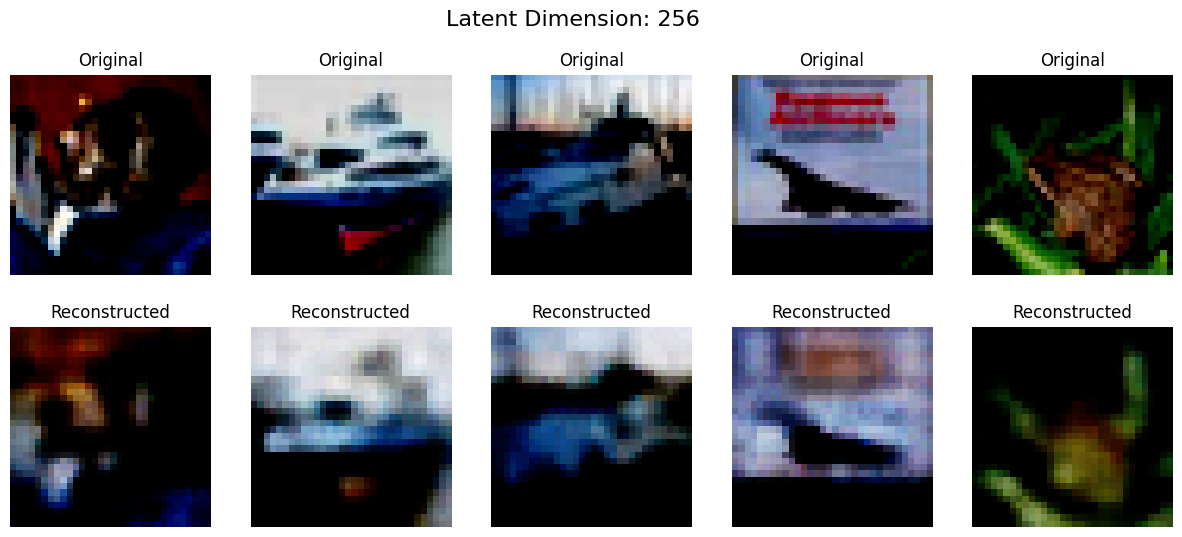

100%|██████████| 10/10 [00:54<00:00,  5.48s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


Latent Dim: 128, Compression: 95.83%, Reconstruction Error: 0.1492


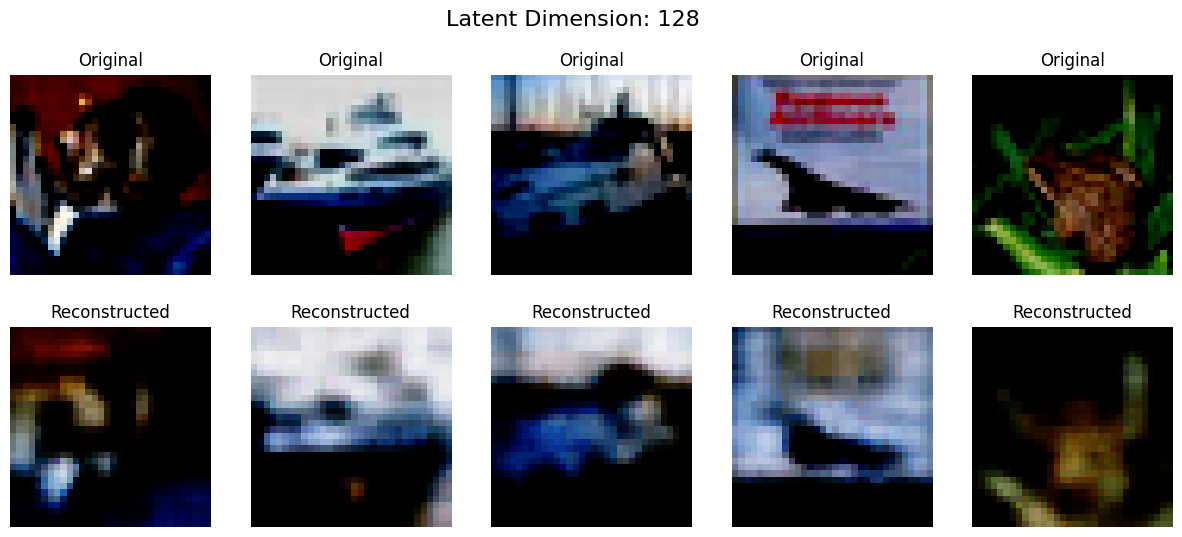

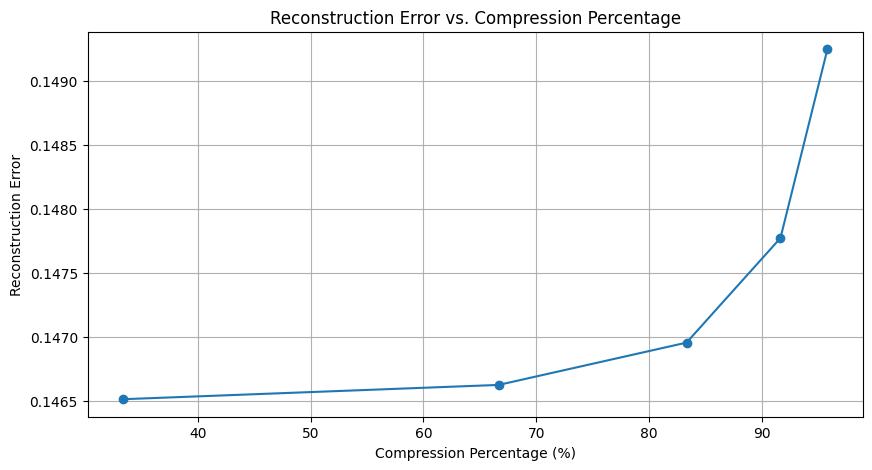

In [10]:
def plot_reconstructed_images(model, latent_dim, num_images=5):
    model.eval()
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    images = images[:num_images].to(device)
    output = model(images)
    
    # Move the images back to CPU for visualization
    images = images.cpu().detach().numpy()
    output = output.cpu().detach().numpy()
    
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # Display original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].transpose((1, 2, 0)))
        plt.title("Original")
        plt.axis('off')
        
        # Display reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(output[i].transpose((1, 2, 0)))
        plt.title("Reconstructed")
        plt.axis('off')
    plt.suptitle(f'Latent Dimension: {latent_dim}', fontsize=16)
    plt.show()

# Function to calculate reconstruction error
def calculate_reconstruction_error(model):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

# Function to calculate percentage of compression
def calculate_compression_percentage(latent_dim):
    original_size = 3 * 32 * 32  # CIFAR-10 image size
    compressed_size = latent_dim
    return 100 * (1 - (compressed_size / original_size))

# Hyperparameters
latent_dims = [2048, 1024, 512, 256, 128]
num_epochs = 10
learning_rate = 0.001
batch_size = 128

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to train the model
def train_model(latent_dim):
    model = Autoencoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in tqdm(range(num_epochs)):
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            # Forward pass
            output = model(img)
            loss = criterion(output, img)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    return model, loss.item()


# Collect data
compression_percentages = []
reconstruction_errors = []

for latent_dim in latent_dims:
    model, loss = train_model(latent_dim)
    recon_error = calculate_reconstruction_error(model)
    compression_percentage = calculate_compression_percentage(latent_dim)
    
    compression_percentages.append(compression_percentage)
    reconstruction_errors.append(recon_error)
    print(f'Latent Dim: {latent_dim}, Compression: {compression_percentage:.2f}%, Reconstruction Error: {recon_error:.4f}')
    plot_reconstructed_images(model, latent_dim)


# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(compression_percentages, reconstruction_errors, marker='o')
plt.title('Reconstruction Error vs. Compression Percentage')
plt.xlabel('Compression Percentage (%)')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()


## The error starts increasing by a big margin starting from compression percentage = 67% (latent_dim = 1024) 